In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 50) 

stud_math = pd.read_csv('stud_math.xls')

In [10]:
display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

В данном датасете всего 395 строк (учеников). 13 числовых столбцов, 17 строковых. В большинстве строк есть пустые значения, но их не много.

In [11]:
# Отредактируем названия столбцов для удобства использования в дальнейшем
stud_math.rename(columns = {'Pstatus' : 'pstatus','Medu' : 'medu', 'Fedu' : 'fedu', 
                            'Mjob' : 'mjob', 'Fjob' : 'fjob','studytime, granular' : 'studytime_granular'
                           }, inplace = True)


In [12]:
def primary_analysis_num(column, lower_bound=0, upper_bound=0):
    '''Производит первичный анализ числовых столбцов'''
    display(stud_math[column].describe())
    print(f'Процент пропусков {round(len(stud_math[stud_math[column].isna()]) / 395 * 100, 2)}%')
    q25 = stud_math[column].quantile(0.25)
    q75 = stud_math[column].quantile(0.75)
    iqr = q75 - q25
    if lower_bound==0 and upper_bound==0:
        lower_bound = q25 - iqr*1.5
        upper_bound = q75 + iqr*1.5
    print(f'25й квантиль: {q25}, 75й квантиль: {q75}, IQR: {iqr}, Границы выбросов: [{lower_bound}, {upper_bound}]')
    stud_math[column].loc[stud_math[column].between(lower_bound, upper_bound)].\
                      hist(bins = len(stud_math[column].loc[stud_math[column].between(lower_bound, upper_bound)].value_counts()),
                           range = (lower_bound, upper_bound), 
                           label = 'Типичные показатели')
    stud_math[column].hist(bins = len(stud_math[column].value_counts()),
                           range = (stud_math[column].min(), stud_math[column].max()), 
                           alpha = 0.5, 
                           label = 'Все показатели')
    plt.legend()

In [13]:
def primary_analysis(column):
    '''Первичный анализ для номинативных столбцов'''
    sns.countplot(stud_math.loc[:, column])
    display(stud_math[column].value_counts())
    print(f'Процент пропусков {round(len(stud_math[stud_math[column].isna()]) / 395 * 100, 2)}%')
    print(f'Уникальных значений: {len(stud_math[column].value_counts())}')

In [14]:
def get_boxplot(column):
    '''Создание boxplot для каждого признака'''
    fig, ax = plt.subplots(figsize = (17, 4))
    sns.boxplot(x=column, y='score', 
               data = stud_math, 
               ax=ax)
    plt.xticks(rotation=45)
    
    ax.set_title('Boxplot for ' + column)
    plt.show()
    

# Score

Для начала рассмотрим целевую переменную

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Процент пропусков 1.52%
25й квантиль: 40.0, 75й квантиль: 70.0, IQR: 30.0, Границы выбросов: [-5.0, 115.0]


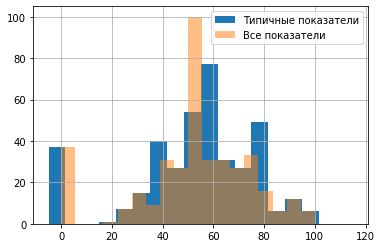

In [15]:
primary_analysis_num('score')

В целевой переменной есть пропуски, их нужно удалить, т.к. это не принесет никакой полезной информации для будущей модели. Так же заметим что минимальный балл = 0, а максимальный = 100. Эти показатели можно считать границами выбросов.  

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Процент пропусков 0.0%
25й квантиль: 40.0, 75й квантиль: 70.0, IQR: 30.0, Границы выбросов: [0, 100]


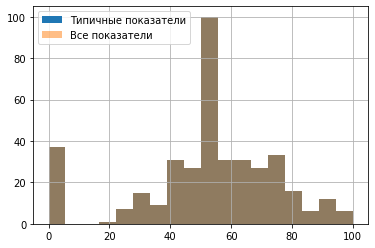

In [16]:
stud_math.dropna(subset = ['score'],inplace=True)
primary_analysis_num('score', 0, 100)

По графику видно, что значений от 0 до 20 нет, возможно 20 баллов - это минимальный проходной балл, ниже которого баллы не засчитываются. Так же можно заметить, что все баллы кратны 5, возможно 1 задание стоит 5 баллов.

# School

GP    344
MS     45
Name: school, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


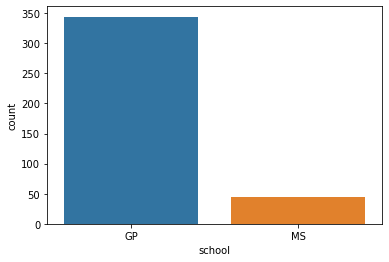

In [17]:
primary_analysis('school')

В датасете представлены ученики 2х школ. Пропусков нет. Учеников из школы GP намного больше.

# Sex

F    204
M    185
Name: sex, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


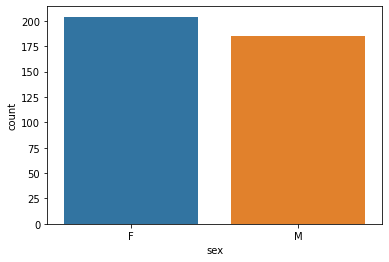

In [18]:
primary_analysis('sex')

Пропусков нет. Учеников женского пола немного больше.

# Age

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Процент пропусков 0.0%
25й квантиль: 16.0, 75й квантиль: 18.0, IQR: 2.0, Границы выбросов: [15, 22]


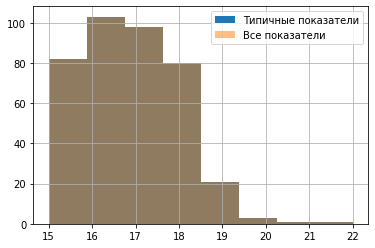

In [19]:
primary_analysis_num('age', 15, 22)

Выбросов нет. Пропусков нет. Большинство учеников в возрасте от 15 до 18 лет.

# Address

U    291
R     83
Name: address, dtype: int64

Процент пропусков 3.8%
Уникальных значений: 2


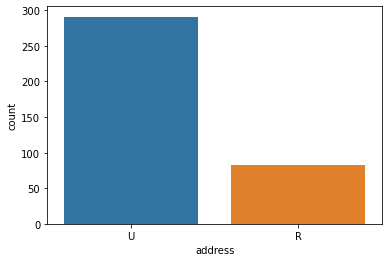

In [20]:
primary_analysis('address')

Пропуски есть, но их мало. Заменим пропущенные значения модой - 'U'.

In [21]:
stud_math['address'] = stud_math['address'].apply(lambda x: 'U' if pd.isnull(x) else x)

U    306
R     83
Name: address, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


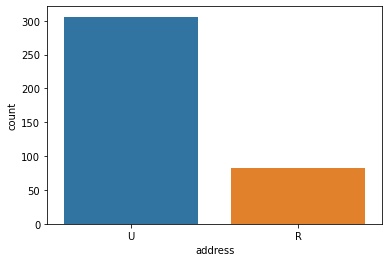

In [22]:
primary_analysis('address')

Адрес U намного чаще встречается в датасете.

# Famsize

GT3    255
LE3    107
Name: famsize, dtype: int64

Процент пропусков 6.84%
Уникальных значений: 2


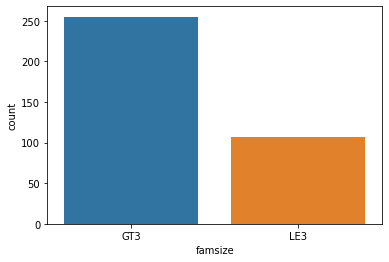

In [23]:
primary_analysis('famsize')

Небольшое количество пропусков. Пропуски заменим на моду - 'GT3'.

In [24]:
stud_math['famsize'] = stud_math['famsize'].apply(lambda x: 'GT3' if pd.isnull(x) else x)

GT3    282
LE3    107
Name: famsize, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


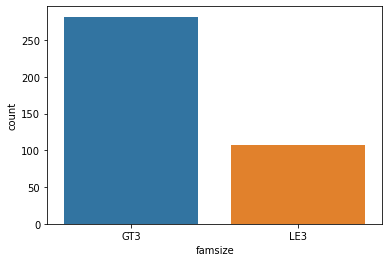

In [25]:
primary_analysis('famsize')

Семей, состоящих из 4 и более человек намного больше.

# Pstatus

T    308
A     36
Name: pstatus, dtype: int64

Процент пропусков 11.39%
Уникальных значений: 2


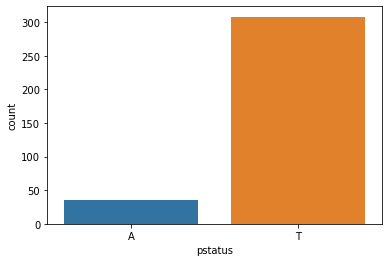

In [26]:
primary_analysis('pstatus')

Пропусков не очень много, заменим их на моду - 'T'.

In [27]:
stud_math['pstatus'] = stud_math['pstatus'].apply(lambda x: 'T' if pd.isnull(x) else x)

T    353
A     36
Name: pstatus, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


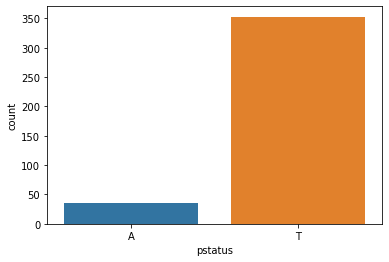

In [28]:
primary_analysis('pstatus')

Родители почти всех учеников проживают совместно.

# Medu

count    386.000000
mean       2.766839
std        1.094277
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

Процент пропусков 0.76%
25й квантиль: 2.0, 75й квантиль: 4.0, IQR: 2.0, Границы выбросов: [0, 4]


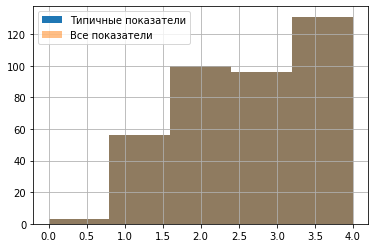

In [29]:
primary_analysis_num('medu', 0, 4)

Выбросов нет. Очень маленькое количество пропусков. Заменим пропуски на медианное значение - 3.

In [30]:
stud_math['medu'] = stud_math['medu'].apply(lambda x: 3.0 if pd.isnull(x) else x)

count    389.000000
mean       2.768638
std        1.090230
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

Процент пропусков 0.0%
25й квантиль: 2.0, 75й квантиль: 4.0, IQR: 2.0, Границы выбросов: [0, 4]


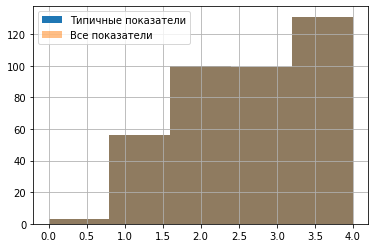

In [31]:
primary_analysis_num('medu', 0, 4)

Практически все матери имеют образование. Большинство из них имееют высшее.

# Fedu

count    365.000000
mean       2.627397
std        2.241790
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: fedu, dtype: float64

Процент пропусков 6.08%
25й квантиль: 2.0, 75й квантиль: 3.0, IQR: 1.0, Границы выбросов: [0, 4]


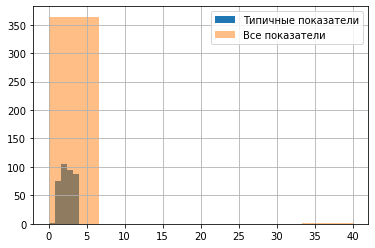

In [32]:
primary_analysis_num('fedu', 0, 4)

Есть пропуски. И есть выброс. Значения могут принимать от 0 до 4. Предположим что 40 - это опечатка, и там должна быть написана цифра 4. Так же заменим пропущенные значения на медианное.

In [33]:
stud_math['fedu'] = stud_math['fedu'].apply(lambda x: 4.0 if x == 40 else 3 if pd.isnull(x) else x)

count    389.000000
mean       2.557841
std        1.059990
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: fedu, dtype: float64

Процент пропусков 0.0%
25й квантиль: 2.0, 75й квантиль: 3.0, IQR: 1.0, Границы выбросов: [0, 4]


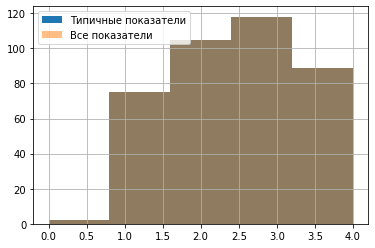

In [34]:
primary_analysis_num('fedu', 0, 4)

Почти все отцы имеют образование. Большинство среднее специальное. 

# Mjob

other       127
services     98
at_home      58
teacher      55
health       32
Name: mjob, dtype: int64

Процент пропусков 4.81%
Уникальных значений: 5


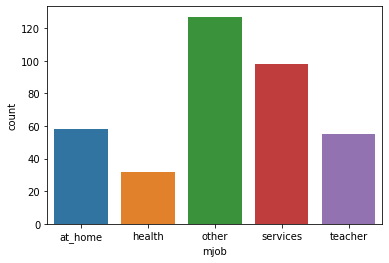

In [35]:
primary_analysis('mjob')

Есть небольшое количество пропусков. Можно заполнить пропуски модой - 'other'.

In [36]:
stud_math['mjob'] = stud_math['mjob'].apply(lambda x: 'other' if pd.isnull(x) else x)

other       146
services     98
at_home      58
teacher      55
health       32
Name: mjob, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 5


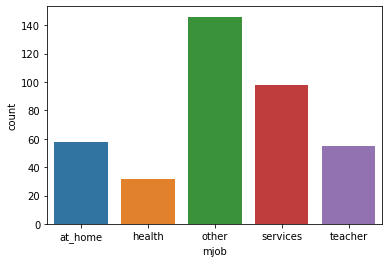

In [37]:
primary_analysis('mjob')

Большинство профессий не было представлено в списке, поэтому в анкете пришлось указать значение 'other', что и стало самым популярным значением в этом датасете.

# Fjob

other       194
services     99
teacher      29
at_home      16
health       15
Name: fjob, dtype: int64

Процент пропусков 9.11%
Уникальных значений: 5


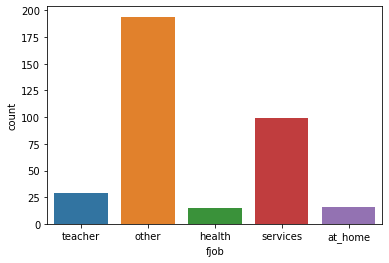

In [38]:
primary_analysis('fjob')

Небольшое количество пропусков. Заменим пропуски значения моды - 'other'.

In [39]:
stud_math['fjob'] = stud_math['fjob'].apply(lambda x: 'other' if pd.isnull(x) else x)

other       230
services     99
teacher      29
at_home      16
health       15
Name: fjob, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 5


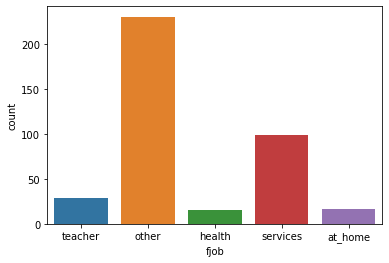

In [40]:
primary_analysis('fjob')

Сфера деятельности очень большого количества отцов учеников не была указана в выборе анкеты, поэтому ответ - 'other' намного популярнее остальных.

# Reason

course        135
reputation    102
home          101
other          34
Name: reason, dtype: int64

Процент пропусков 4.3%
Уникальных значений: 4


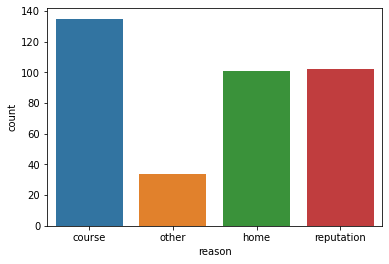

In [41]:
primary_analysis('reason')

Есть небольшое количество пропусков. Большинство ценят образовательную программу в этой школе, поэтому заменим пропуски на значение course.

In [42]:
stud_math['reason'] = stud_math['reason'].apply(lambda x: 'course' if pd.isnull(x) else x)

course        152
reputation    102
home          101
other          34
Name: reason, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 4


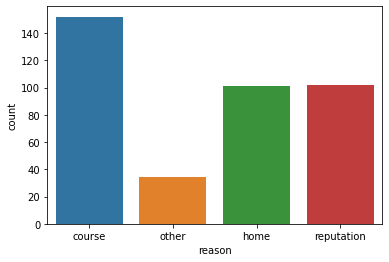

In [43]:
primary_analysis('reason')

Большинство ценят образовательную программу в этой школе. 

# Guardian

mother    248
father     86
other      24
Name: guardian, dtype: int64

Процент пропусков 7.85%
Уникальных значений: 3


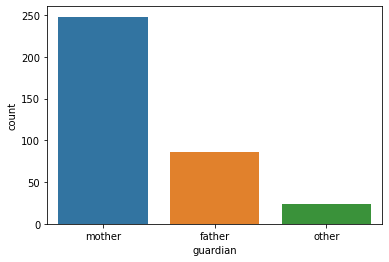

In [44]:
primary_analysis('guardian')

Есть небольшое количество пропусков. Заменим пропущенные значения на моду - 'mother'.

In [45]:
stud_math['guardian'] = stud_math['guardian'].apply(lambda x: 'mother' if pd.isnull(x) else x)

mother    279
father     86
other      24
Name: guardian, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 3


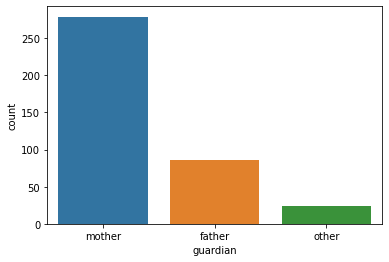

In [46]:
primary_analysis('guardian')

У преимущественного большинства учеников опекуном является мать. 

# Traveltime

count    361.000000
mean       1.434903
std        0.692660
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

Процент пропусков 7.09%
25й квантиль: 1.0, 75й квантиль: 2.0, IQR: 1.0, Границы выбросов: [1, 4]


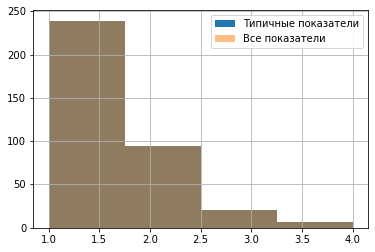

In [47]:
primary_analysis_num('traveltime', 1, 4)

Выбросов нет. Пропусков немного, их можно заполнить медианным значением.

In [48]:
stud_math['traveltime'] = stud_math['traveltime'].apply(lambda x: 1.0 if pd.isnull(x) else x)

count    389.000000
mean       1.403599
std        0.676625
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

Процент пропусков 0.0%
25й квантиль: 1.0, 75й квантиль: 2.0, IQR: 1.0, Границы выбросов: [1, 4]


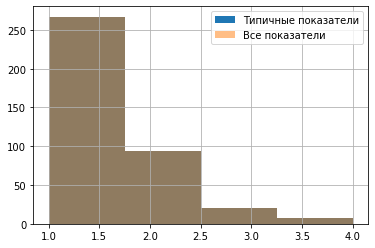

In [49]:
primary_analysis_num('traveltime', 1, 4)

По графику видно, что чем больше расстояние до школы, тем меньше учеников. То есть большинство учеников тратит на дорогу менее 15 минут. 

# Studytime

count    382.000000
mean       2.036649
std        0.847239
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

Процент пропусков 1.77%
25й квантиль: 1.0, 75й квантиль: 2.0, IQR: 1.0, Границы выбросов: [1, 4]


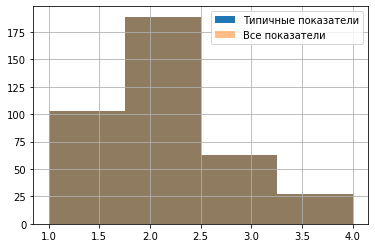

In [50]:
primary_analysis_num('studytime', 1, 4)

Очень мало пропусков. Выбросов нет. 2 - является сразу и медианой, и средним значением, и модой. Заменим пропуски значением 2.

In [51]:
stud_math['studytime'] = stud_math['studytime'].apply(lambda x: 2.0 if pd.isnull(x) else x)

count    389.000000
mean       2.035990
std        0.839575
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

Процент пропусков 0.0%
25й квантиль: 1.0, 75й квантиль: 2.0, IQR: 1.0, Границы выбросов: [1, 4]


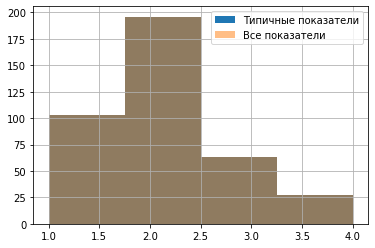

In [52]:
primary_analysis_num('studytime', 1, 4)

 По графику видно, что большинство учеников занимается от 2 до 5 часов в неделю дополнительно, помимо школы. 

# Failures

count    367.000000
mean       0.326975
std        0.729479
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

Процент пропусков 5.57%
25й квантиль: 0.0, 75й квантиль: 0.0, IQR: 0.0, Границы выбросов: [0, 3]


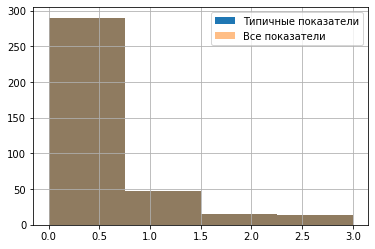

In [53]:
primary_analysis_num('failures', 0, 3)

Пропусков мало. Их можно заполнить значением 0, которое является одновременно и медианой и модой и средним значением.

In [54]:
stud_math['failures'] = stud_math['failures'].apply(lambda x: 0.0 if pd.isnull(x) else x)

count    389.000000
mean       0.308483
std        0.712521
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

Процент пропусков 0.0%
25й квантиль: 0.0, 75й квантиль: 0.0, IQR: 0.0, Границы выбросов: [0, 3]


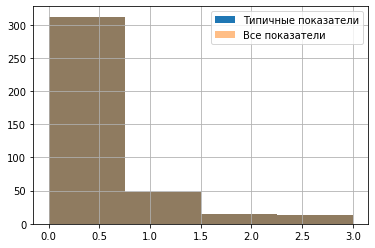

In [55]:
primary_analysis_num('failures', 0, 3)

Слишком много значений 0, что может являться как и признаком отсутсвия неудач, так и наоборот большим его количеством.

# Schoolsup

no     331
yes     49
Name: schoolsup, dtype: int64

Процент пропусков 2.28%
Уникальных значений: 2


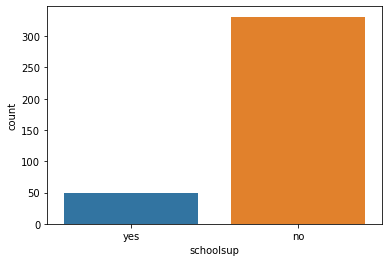

In [56]:
primary_analysis('schoolsup')

Есть небольшое количество пропусков. Заменим их модой - значением 'no'.

In [57]:
stud_math['schoolsup'] = stud_math['schoolsup'].apply(lambda x: 'yes' if pd.isnull(x) else x)

no     331
yes     58
Name: schoolsup, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


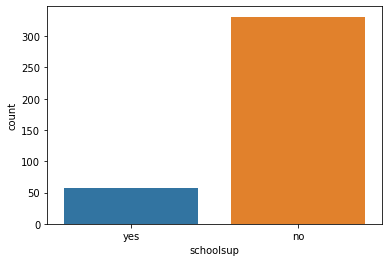

In [58]:
primary_analysis('schoolsup')

Значений 'no' намного больше, чем значений 'yes'.

# Famsup

yes    216
no     135
Name: famsup, dtype: int64

Процент пропусков 9.62%
Уникальных значений: 2


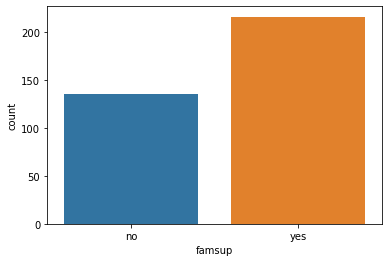

In [59]:
primary_analysis('famsup')

Есть небольшое количество пропусков. Заменим их модой - значением 'yes'

In [60]:
stud_math['famsup'] = stud_math['famsup'].apply(lambda x: 'yes' if pd.isnull(x) else x)

yes    254
no     135
Name: famsup, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


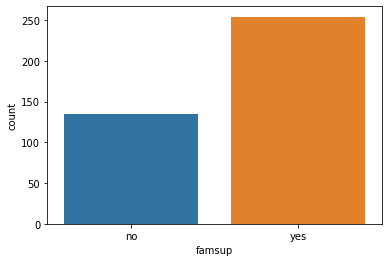

In [61]:
primary_analysis('famsup')

У большинства учеников есть семейная образовательная поддержка.

# Paid

no     197
yes    153
Name: paid, dtype: int64

Процент пропусков 9.87%
Уникальных значений: 2


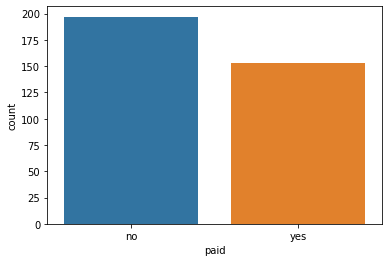

In [62]:
primary_analysis('paid')

Есть пропуски. Заменим их модой - значением 'no'.

In [63]:
stud_math['paid'] = stud_math['paid'].apply(lambda x: 'no' if pd.isnull(x) else x)

no     236
yes    153
Name: paid, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


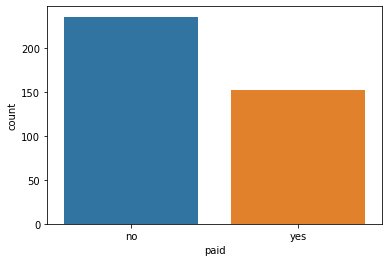

In [64]:
primary_analysis('paid')

Большинство учеников не занимаются платными занятиями по математике.

# Activities

yes    192
no     183
Name: activities, dtype: int64

Процент пропусков 3.54%
Уникальных значений: 2


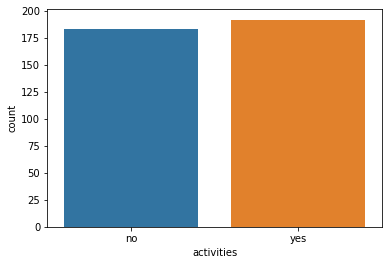

In [65]:
primary_analysis('activities')

Есть небольшое количество пропусков. Заменим их модой - 'yes'.

In [66]:
stud_math['activities'] = stud_math['activities'].apply(lambda x: 'yes' if pd.isnull(x) else x)

yes    206
no     183
Name: activities, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


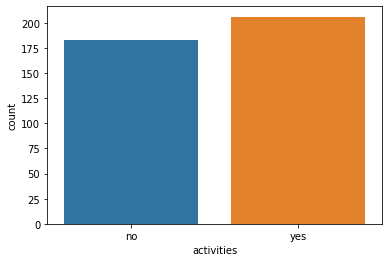

In [67]:
primary_analysis('activities')


Немного больше учеников, которые занимаются дополнительно.

# Nursery

yes    297
no      77
Name: nursery, dtype: int64

Процент пропусков 3.8%
Уникальных значений: 2


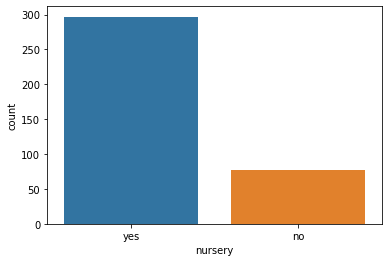

In [68]:
primary_analysis('nursery')

Есть пропуски. Заменим модой - значением 'yes'.

In [69]:
stud_math['nursery'] = stud_math['nursery'].apply(lambda x: 'yes' if pd.isnull(x) else x)

yes    312
no      77
Name: nursery, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


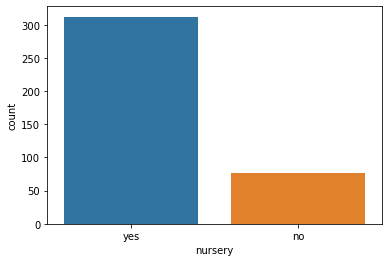

In [70]:
primary_analysis('nursery')

Намного больше учеников посещали детский сад.

# Studytime, granular

count    382.000000
mean      -6.109948
std        2.541716
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime_granular, dtype: float64

Процент пропусков 1.77%
25й квантиль: -6.0, 75й квантиль: -3.0, IQR: 3.0, Границы выбросов: [-10.5, 1.5]


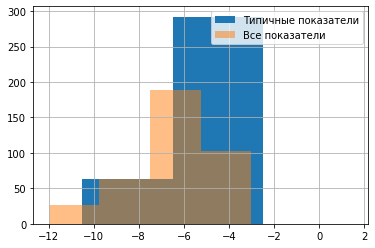

In [71]:
primary_analysis_num('studytime_granular')

Есть выбросы, но возможно они входят в пределы нормы. Заменим границы выбросов минимальным и максимальным значением этого столбца. Так же присутствует небольшое количество пропусков. Заменим их медианой.

In [72]:
stud_math['studytime_granular'] = stud_math['studytime_granular'].apply(lambda x: -6.0 if pd.isnull(x) else x)

count    389.000000
mean      -6.107969
std        2.518726
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime_granular, dtype: float64

Процент пропусков 0.0%
25й квантиль: -6.0, 75й квантиль: -3.0, IQR: 3.0, Границы выбросов: [-12, -3]


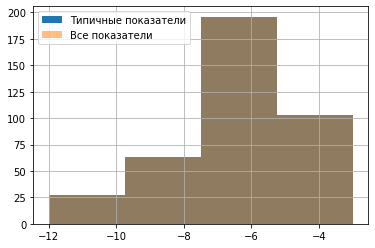

In [73]:
primary_analysis_num('studytime_granular', -12, -3)

# Higher

yes    350
no      19
Name: higher, dtype: int64

Процент пропусков 5.06%
Уникальных значений: 2


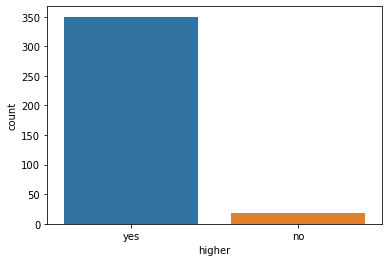

In [74]:
primary_analysis('higher')

Есть небольшое количество пропусков. Заменим их модой - значением 'yes'.

In [75]:
stud_math['higher'] = stud_math['higher'].apply(lambda x: 'yes' if pd.isnull(x) else x)

yes    370
no      19
Name: higher, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


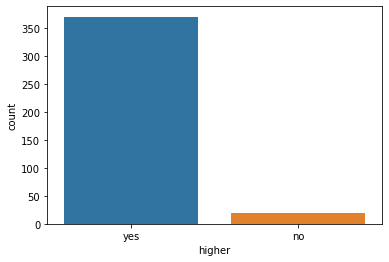

In [76]:
primary_analysis('higher')

Практически все ученики хотят получить высшее образование.

# Internet 

yes    300
no      55
Name: internet, dtype: int64

Процент пропусков 8.61%
Уникальных значений: 2


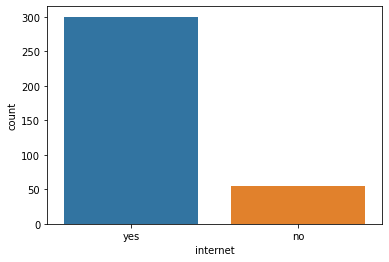

In [77]:
primary_analysis('internet')

Есть небольшое количество пропусков. Заменим их модой - значением 'yes'.

In [78]:
stud_math['internet'] = stud_math['internet'].apply(lambda x: 'yes' if pd.isnull(x) else x)

yes    334
no      55
Name: internet, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


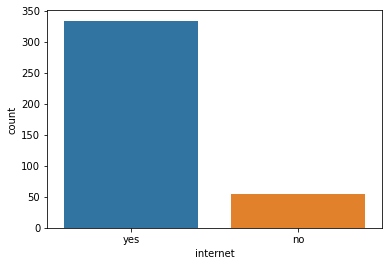

In [79]:
primary_analysis('internet')

У большинства учеников есть интернет дома.

# Romantic

no     235
yes    123
Name: romantic, dtype: int64

Процент пропусков 7.85%
Уникальных значений: 2


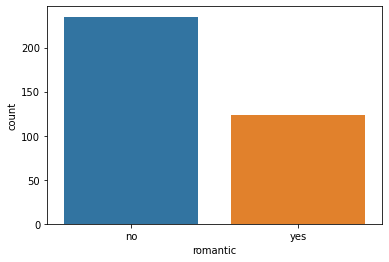

In [80]:
primary_analysis('romantic')

Есть небольшое количество пропусков. Заменим их модой - значением 'no.

In [81]:
stud_math['romantic'] = stud_math['romantic'].apply(lambda x: 'no' if pd.isnull(x) else x)

no     266
yes    123
Name: romantic, dtype: int64

Процент пропусков 0.0%
Уникальных значений: 2


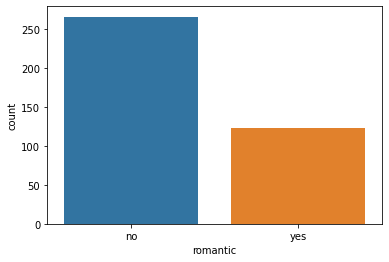

In [82]:
primary_analysis('romantic')

Большинство учеников не состоят в романтических отношениях.

# Famrel

count    362.000000
mean       3.930939
std        0.931554
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

Процент пропусков 6.84%
25й квантиль: 4.0, 75й квантиль: 5.0, IQR: 1.0, Границы выбросов: [1, 5]


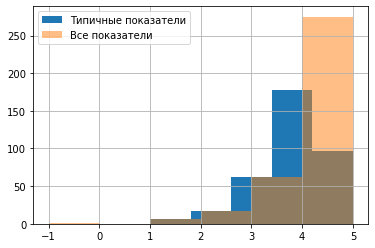

In [83]:
primary_analysis_num('famrel', 1, 5)

Есть выброс в виде знаяения -1. Либо это опечатка и значение должно быть 1, либо отношения настолько плохие, что опрашиваемый поставил оценку -1. В любом случае можно предположить, что значение должно равняться 1. Так же есть несколько пропущенных значений, заменим их медианой - 4.

In [84]:
stud_math['famrel'] = stud_math['famrel'].apply(lambda x: 1 if x == -1 else 4 if pd.isnull(x) else x )


count    389.000000
mean       3.940874
std        0.875850
min        1.000000
25%        4.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: famrel, dtype: float64

Процент пропусков 0.0%
25й квантиль: 4.0, 75й квантиль: 4.0, IQR: 0.0, Границы выбросов: [1, 5]


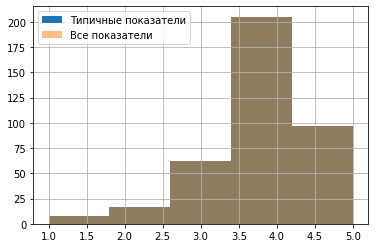

In [85]:
primary_analysis_num('famrel', 1, 5)

По графику  видно что в большинстве семей отношения оцениваются выше среднего.

# Freetime

count    380.000000
mean       3.223684
std        0.993364
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

Процент пропусков 2.28%
25й квантиль: 3.0, 75й квантиль: 4.0, IQR: 1.0, Границы выбросов: [1, 5]


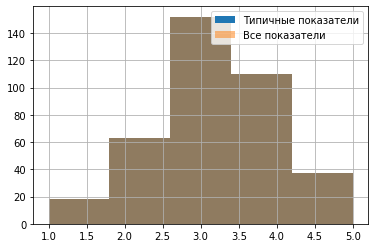

In [86]:
primary_analysis_num('freetime', 1, 5)

Выбросов нет. Есть небольшое количество пропусков. Заменим его числом 3 - это и медиана, и среднее, и мода одновременно.

In [87]:
stud_math['freetime'] = stud_math['freetime'].apply(lambda x: 3 if pd.isnull(x) else x )

count    389.000000
mean       3.218509
std        0.982353
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

Процент пропусков 0.0%
25й квантиль: 3.0, 75й квантиль: 4.0, IQR: 1.0, Границы выбросов: [1, 5]


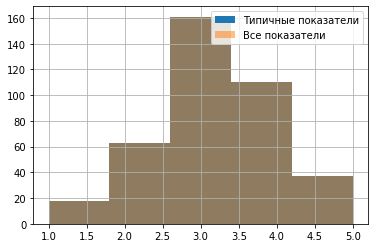

In [88]:
primary_analysis_num('freetime', 1, 5)

Большинству учеников хватает свободного времени.

# Goout

count    382.000000
mean       3.094241
std        1.116104
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

Процент пропусков 1.77%
25й квантиль: 2.0, 75й квантиль: 4.0, IQR: 2.0, Границы выбросов: [1, 5]


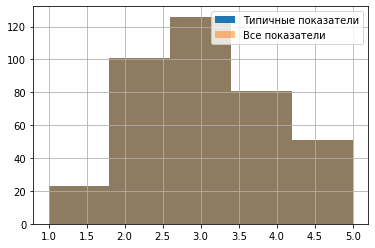

In [89]:
primary_analysis_num('goout', 1, 5)

Выбросов нет. Есть небольшое количество пропусков. Заменим его числом 3 - это и медиана, и среднее, и мода одновременно.

In [90]:
stud_math['goout'] = stud_math['goout'].apply(lambda x: 3 if pd.isnull(x) else x )

count    389.000000
mean       3.092545
std        1.106062
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

Процент пропусков 0.0%
25й квантиль: 2.0, 75й квантиль: 4.0, IQR: 2.0, Границы выбросов: [1, 5]


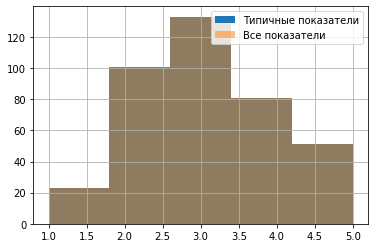

In [91]:
primary_analysis_num('goout', 1, 5)

Большинство учеников проводят достаточное количество времени с друзьями.

# Health

count    374.000000
mean       3.529412
std        1.402006
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

Процент пропусков 3.8%
25й квантиль: 3.0, 75й квантиль: 5.0, IQR: 2.0, Границы выбросов: [1, 5]


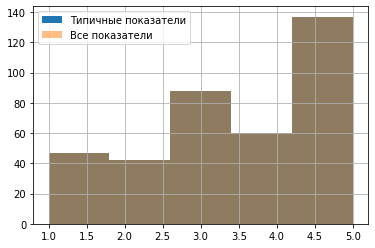

In [92]:
primary_analysis_num('health', 1, 5)

Выбросов нет. Пропусков небольшое количество, заменим их медианой - 4.

In [93]:
stud_math['health'] = stud_math['health'].apply(lambda x: 4 if pd.isnull(x) else x)

count    389.000000
mean       3.547558
std        1.377629
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

Процент пропусков 0.0%
25й квантиль: 3.0, 75й квантиль: 5.0, IQR: 2.0, Границы выбросов: [1, 5]


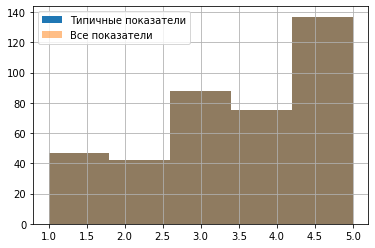

In [94]:
primary_analysis_num('health', 1, 5)

У большинства учеников очень хорошее здоровье.

# Absences

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Процент пропусков 2.78%
25й квантиль: 0.0, 75й квантиль: 8.0, IQR: 8.0, Границы выбросов: [-12.0, 20.0]


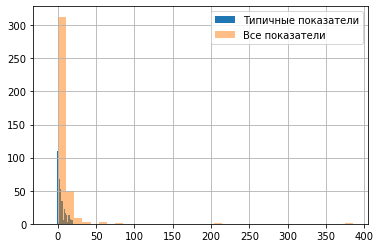

In [95]:
primary_analysis_num('absences')

Выбросы есть. Логично предположить что пропущенных дней не может быть больше, чем учебных дней в году. Поэтому обозначим границы от 0 до 75 (максимально высокое, но при этом разумное значение). А значения выше 75 и небольшое количество пропусков заменим на медианное значение - 4.

In [96]:
stud_math['absences'] = stud_math['absences'].apply(lambda x: 4 if x > 75 or pd.isnull(x) else x)

count    389.000000
mean       5.712082
std        8.003181
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       75.000000
Name: absences, dtype: float64

Процент пропусков 0.0%
25й квантиль: 0.0, 75й квантиль: 8.0, IQR: 8.0, Границы выбросов: [0, 75]


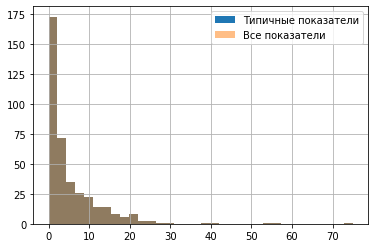

In [97]:
primary_analysis_num('absences', 0, 75)

Большинство учеников совсем не пропускали занятия. Есть единичные случаи достаточно больших пропусков (больше 30).

# Корреляционный анализ

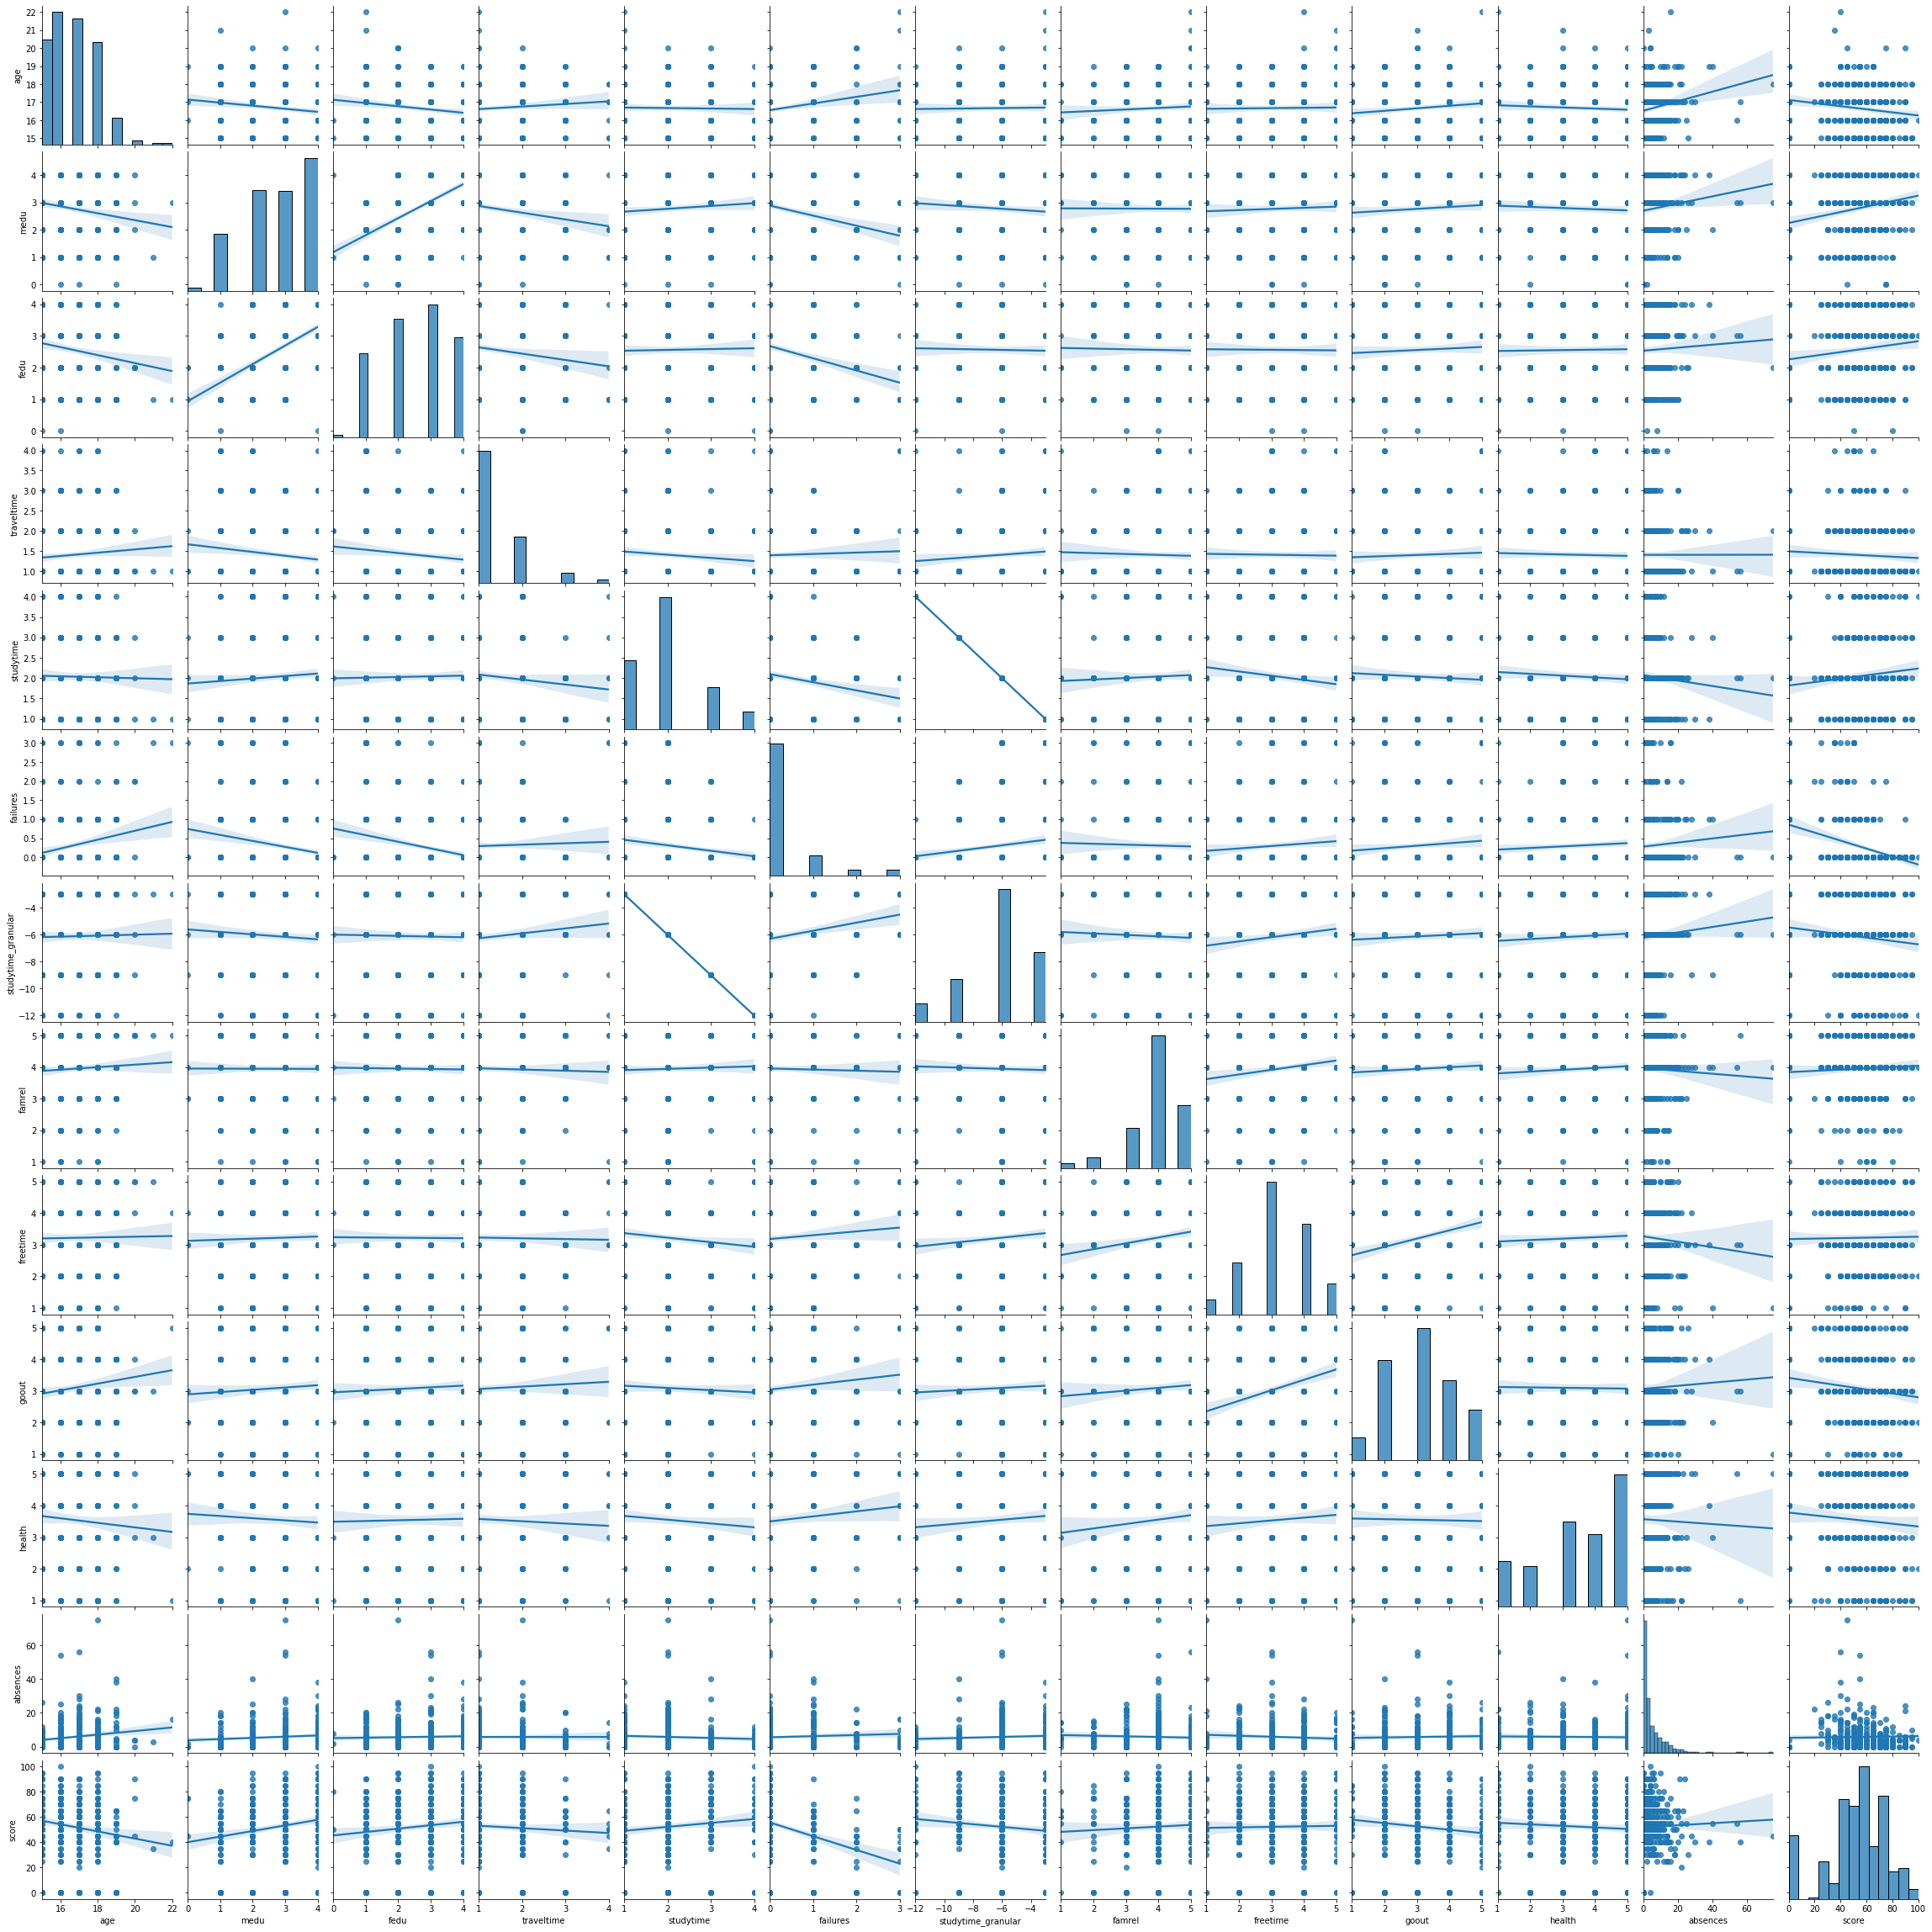

In [98]:
sns.pairplot(stud_math, kind = 'reg')

In [99]:
stud_math.corr()

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.146405,-0.150142,0.076013,-0.018019,0.206279,0.018019,0.056941,0.013994,0.121057,-0.065719,0.167024,-0.155726
medu,-0.146405,1.000000,0.602619,-0.152597,0.079513,-0.239668,-0.079513,-0.003566,0.037699,0.071235,-0.054431,0.096321,0.209758
fedu,-0.150142,0.602619,1.000000,-0.127860,0.020823,-0.259146,-0.020823,-0.017128,-0.008456,0.050380,0.017967,0.035995,0.124559
traveltime,0.076013,-0.152597,-0.127860,1.000000,-0.098226,0.035113,0.098226,-0.029213,-0.016696,0.046390,-0.035852,0.000573,-0.056535
studytime,-0.018019,0.079513,0.020823,-0.098226,1.000000,-0.169399,-1.000000,0.037950,-0.122057,-0.053554,-0.072790,-0.064045,0.114295
failures,0.206279,-0.239668,-0.259146,0.035113,-0.169399,1.000000,0.169399,-0.028517,0.087558,0.101036,0.082165,0.060360,-0.337187
studytime_granular,0.018019,-0.079513,-0.020823,0.098226,-1.000000,0.169399,1.000000,-0.037950,0.122057,0.053554,0.072790,0.064045,-0.114295
famrel,0.056941,-0.003566,-0.017128,-0.029213,0.037950,-0.028517,-0.037950,1.000000,0.164830,0.069514,0.088845,-0.041409,0.052902
freetime,0.013994,0.037699,-0.008456,-0.016696,-0.122057,0.087558,0.122057,0.164830,1.000000,0.294450,0.063718,-0.070327,0.017481
goout,0.121057,0.071235,0.050380,0.046390,-0.053554,0.101036,0.053554,0.069514,0.294450,1.000000,-0.016427,0.035627,-0.127742


Столбцы 'studytime' и 'studytime_granular' полностью скоррелированы. В будущей модели имеет смысл использовать только один из них. Так же положительная корреляция прослеживается у значений medu и fedu.

In [102]:
# Создадим список из номинативных столбцов для удобства их анализа
nom_col = ['school', 'sex', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'guardian', 
           'schoolsup', 'famsup', 'paid', 'activities', 'nursery','higher', 'internet', 'romantic',        
          ]

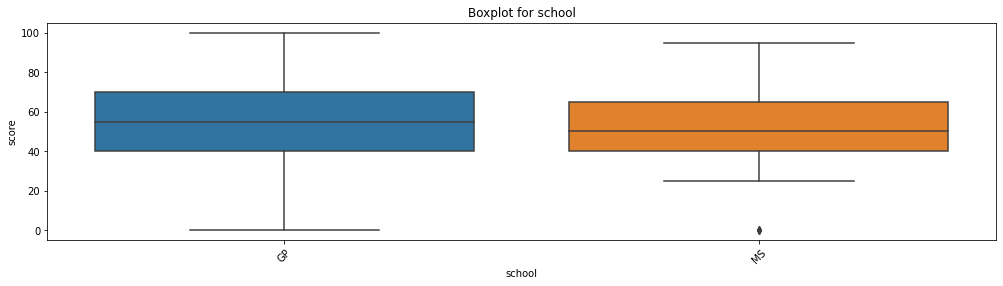

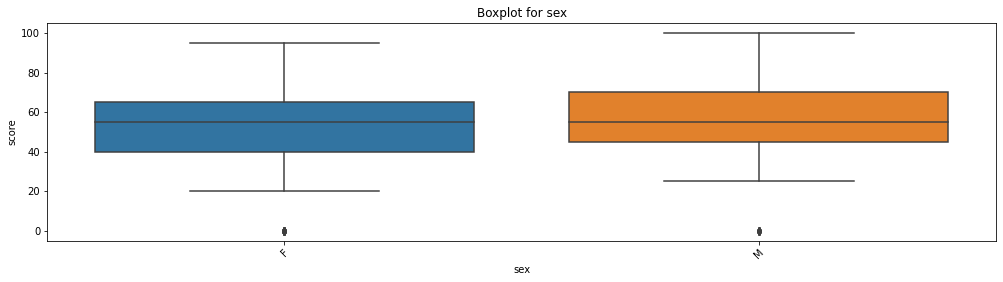

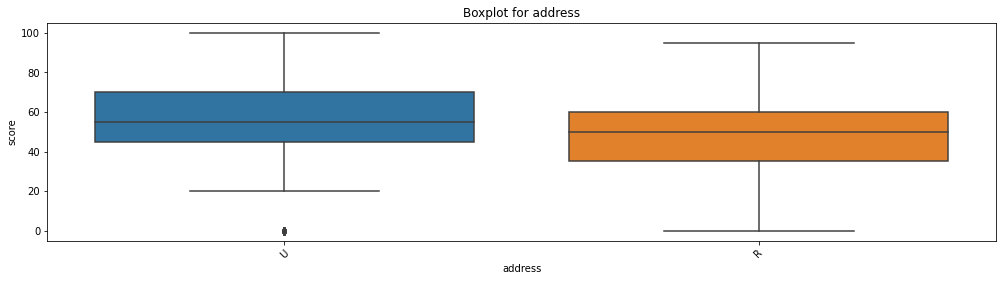

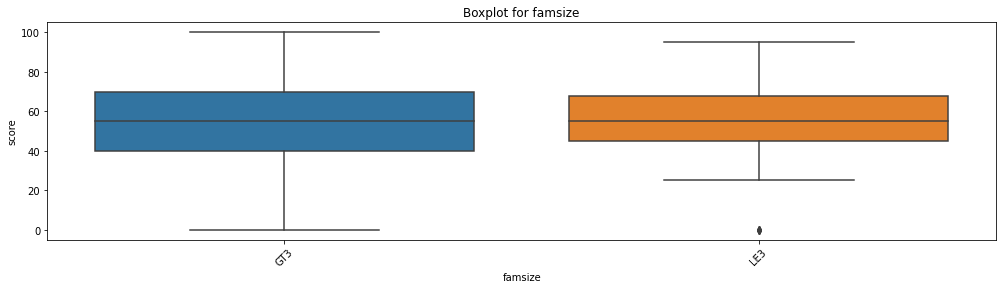

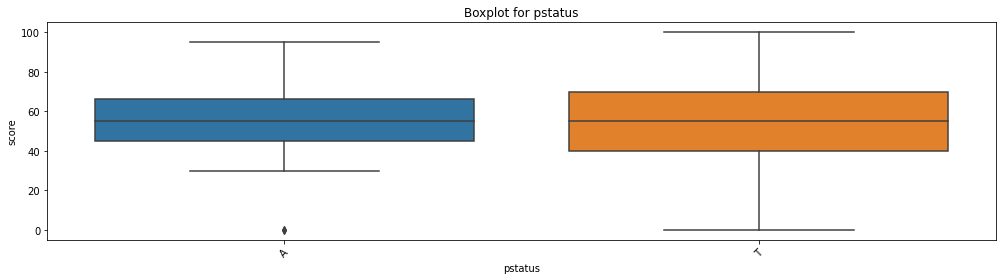

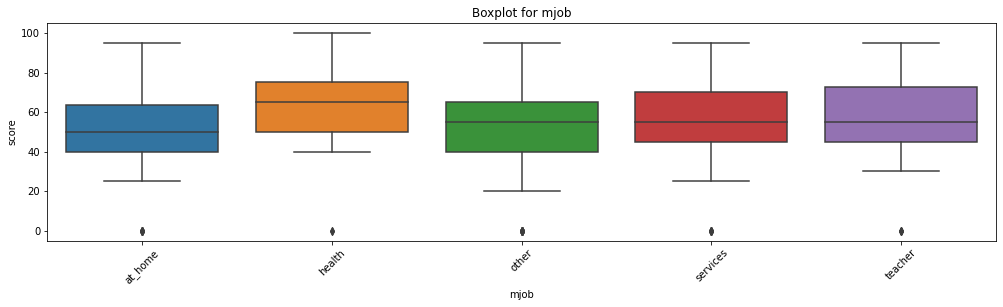

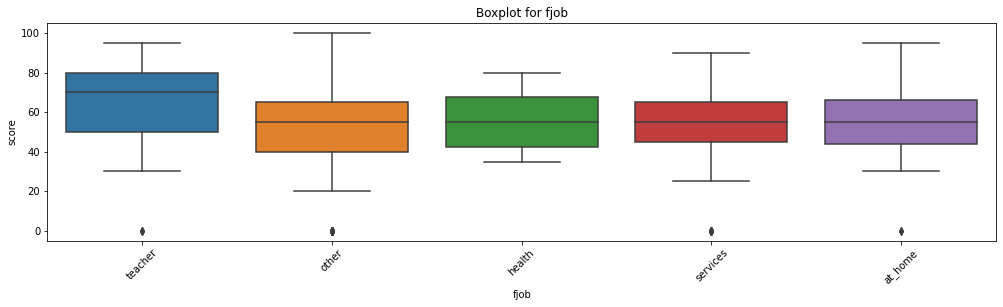

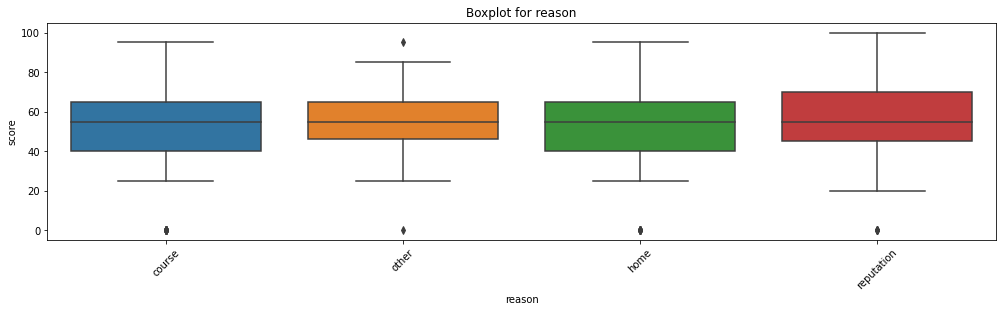

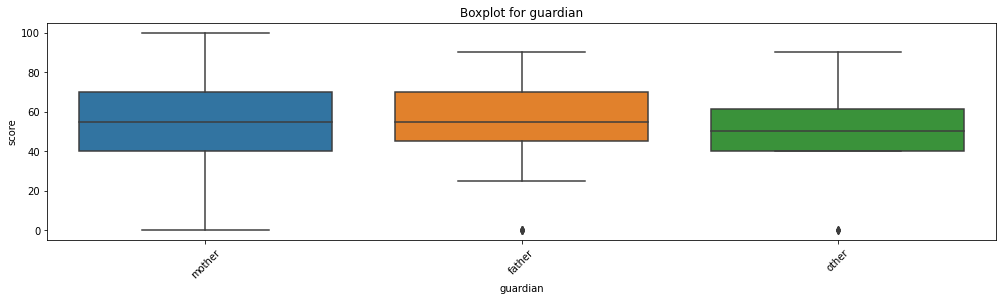

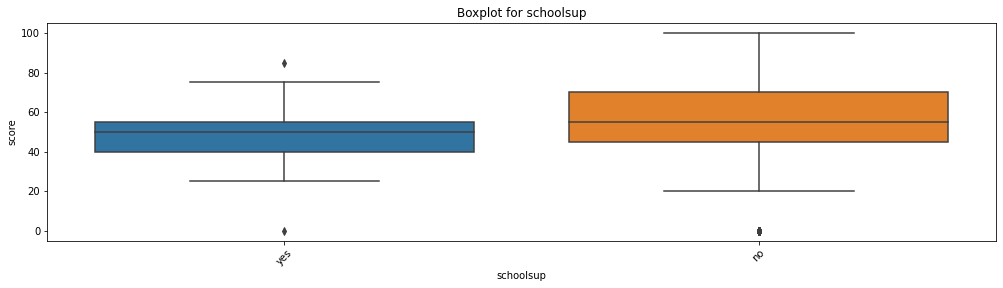

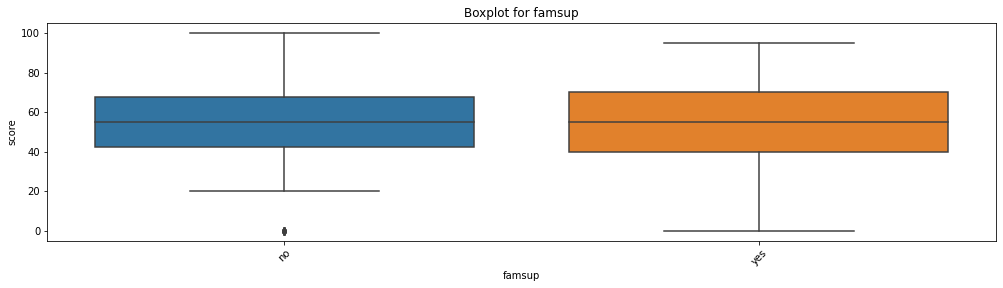

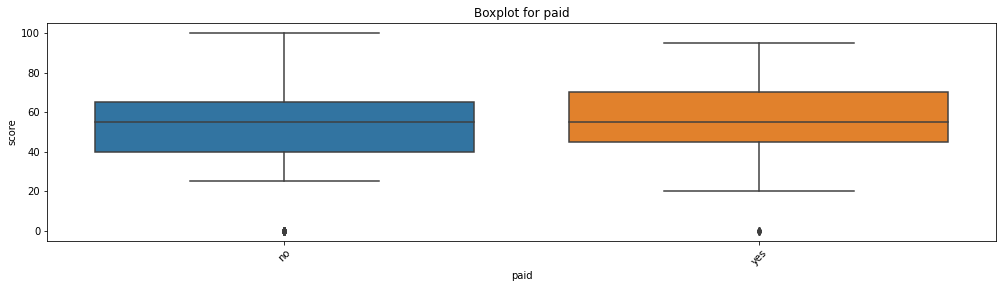

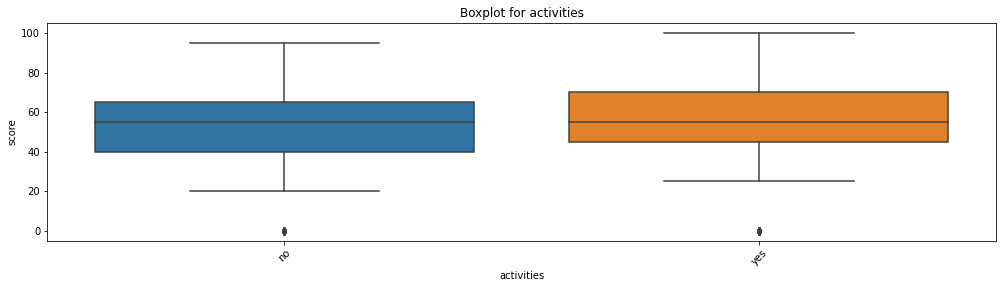

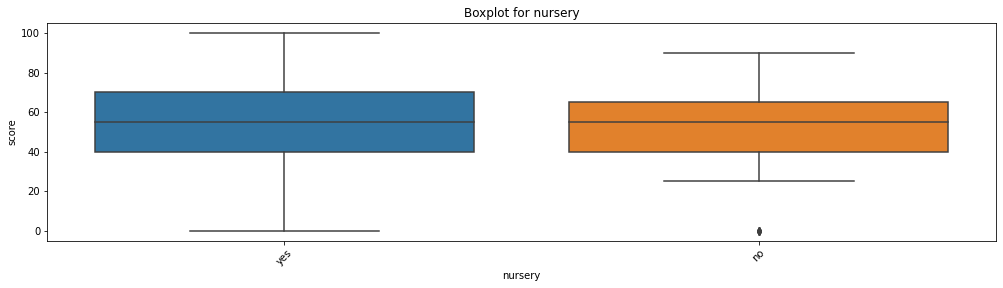

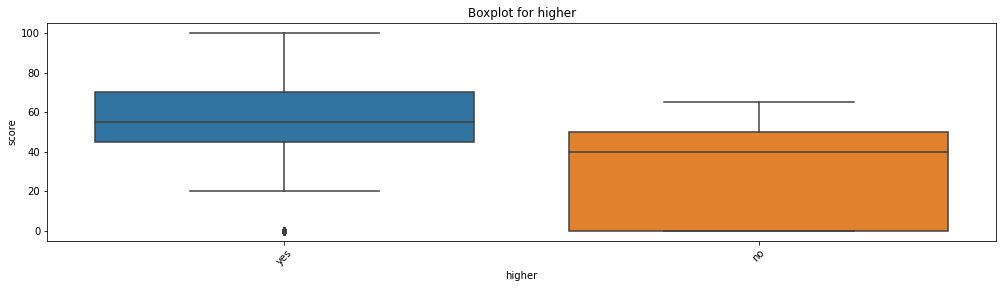

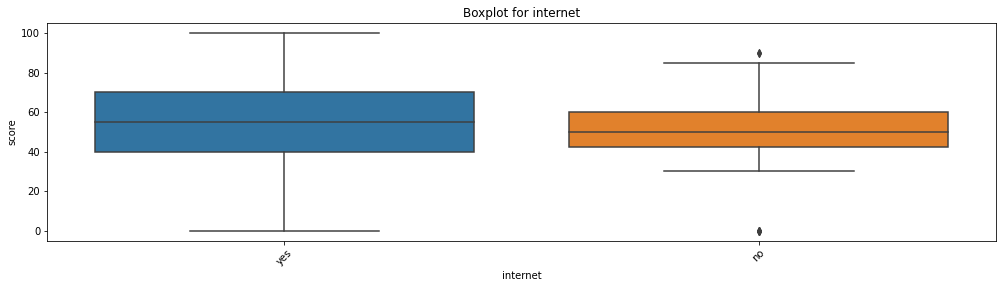

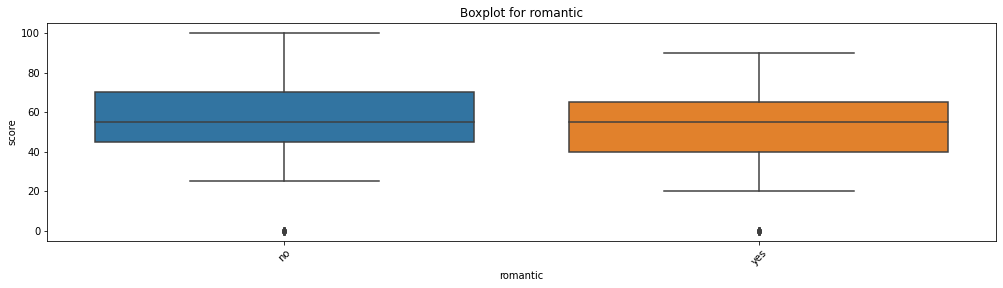

In [103]:
for col in nom_col:
    get_boxplot(col)

По графику видно что параметры mjob, fjob, higher, schoolsup могут влиять на итоговые баллы. Теперь проверим, есть ли статистическая разница в распределении баллов по номинативным признакам с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения баллов по различным параметрам неразличимы:

In [104]:
def get_stat_dif(column):    
    combinations_all = list(combinations(stud_math[column].value_counts(), 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'], 
                        stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    else:
        print('Не найдены статистически значимые различия для колонки', column)
            

In [105]:
for col in nom_col:
    get_stat_dif(col)

Не найдены статистически значимые различия для колонки school
Не найдены статистически значимые различия для колонки sex
Не найдены статистически значимые различия для колонки address
Не найдены статистически значимые различия для колонки famsize
Не найдены статистически значимые различия для колонки pstatus
Не найдены статистически значимые различия для колонки mjob
Не найдены статистически значимые различия для колонки fjob
Не найдены статистически значимые различия для колонки reason
Не найдены статистически значимые различия для колонки guardian
Не найдены статистически значимые различия для колонки schoolsup
Не найдены статистически значимые различия для колонки famsup
Не найдены статистически значимые различия для колонки paid
Не найдены статистически значимые различия для колонки activities
Не найдены статистически значимые различия для колонки nursery
Не найдены статистически значимые различия для колонки higher
Не найдены статистически значимые различия для колонки internet
Не

Ни один из параметров серьезно не отличается. Для дальнейшего построения модели  можно оставить столбцы, которые, возможно влияют на итоговый балл: mjob, fjob, higher, schoolsup

In [106]:
stud_math_for_model = stud_math.loc[:, ['age', 'medu', 'fedu', 'mjob', 'fjob', 'traveltime', 'studytime', 'failures',
                                        'schoolsup', 'higher', 'freetime', 'goout', 'health', 'absences']]
stud_math_for_model.head(10)

,age,medu,fedu,mjob,fjob,traveltime,studytime,failures,schoolsup,higher,freetime,goout,health,absences
0,18,4.0,4.0,at_home,teacher,2.0,2.0,0.0,yes,yes,3.0,4.0,3.0,6.0
1,17,1.0,1.0,at_home,other,1.0,2.0,0.0,no,yes,3.0,3.0,3.0,4.0
2,15,1.0,1.0,at_home,other,1.0,2.0,3.0,yes,yes,3.0,2.0,3.0,10.0
3,15,4.0,2.0,health,other,1.0,3.0,0.0,no,yes,2.0,2.0,5.0,2.0
4,16,3.0,3.0,other,other,1.0,2.0,0.0,no,yes,3.0,2.0,5.0,4.0
5,16,4.0,3.0,services,other,1.0,2.0,0.0,no,yes,4.0,2.0,5.0,10.0
6,16,2.0,2.0,other,other,1.0,2.0,0.0,no,yes,4.0,4.0,3.0,0.0
7,17,4.0,4.0,other,teacher,2.0,2.0,0.0,yes,yes,1.0,4.0,1.0,6.0
8,15,3.0,2.0,services,other,1.0,2.0,0.0,no,yes,2.0,2.0,1.0,0.0
9,15,3.0,4.0,other,other,1.0,2.0,0.0,no,yes,5.0,1.0,5.0,0.0


# Выводы:
- В данных очень мало пустых значений.
- Выбросы найдены только в столбцах: fedu, famrel и absences, значит данные достаточно чистые.
- Отрицательная корреляция параметра score и параметра failures может говорить о том, что люди у которых не было неудач, либо наоборот у которых было больше 4х неудач, получают итоговый балл выше.
- Положительная корреляция score c параметрами medu и fedu может говорить о том, что, чем выше образование у родителей, тем выше итоговый балл.
- Отрицательная корреляция параметра score и параметра age может говорить о том, что чем младше ученик, тем выше итоговый балл.
- Положительная корреляция score с параметром studytime может говорить о том, что чем больше времени ученик тратит на учебу, тем выше у него итоговый балл.
- Отрицательная корреляция score с параметром goout может говорить о том, что чем больше времени ученик проводит с друзьями, тем ниже итоговый балл.
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это age, medu, fedu, mjob, fjob, traveltime, studytime, failures, schoolsup, higher, freetime, goout, health, absences.